<a href="https://colab.research.google.com/github/JaradAng/TF_Action_Recognition/blob/main/Video_Action_Rocognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import libraries needed 
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np
import imageio
import cv2
import os

import math

#Model Specific Libraries
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical



In [3]:
#for reproducibility I am setting the random seeds to 42
np.random.seed(42)
tf.random.set_seed(42)

I will use the ucf50 dataset for this project

In [4]:
# #Bringing in and downloading the UCF50 dataset
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# #Extracting the dataset
# !unrar x UCF50.rar

In [5]:
#Just looking at the data and seeing how many videos are in 

for dirpath, dirnames, filenames in os.walk('UCF50'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} videos in {dirpath}')

There are 50 directories and 0 videos in UCF50
There are 0 directories and 124 videos in UCF50/PlayingTabla
There are 0 directories and 137 videos in UCF50/Rowing
There are 0 directories and 160 videos in UCF50/PlayingGuitar
There are 0 directories and 123 videos in UCF50/HighJump
There are 0 directories and 160 videos in UCF50/BenchPress
There are 0 directories and 137 videos in UCF50/Swing
There are 0 directories and 119 videos in UCF50/TrampolineJumping
There are 0 directories and 100 videos in UCF50/TaiChi
There are 0 directories and 105 videos in UCF50/PlayingPiano
There are 0 directories and 123 videos in UCF50/JumpingJack
There are 0 directories and 111 videos in UCF50/Fencing
There are 0 directories and 117 videos in UCF50/JavelinThrow
There are 0 directories and 120 videos in UCF50/PullUps
There are 0 directories and 114 videos in UCF50/PizzaTossing
There are 0 directories and 153 videos in UCF50/Diving
There are 0 directories and 141 videos in UCF50/Lunges
There are 0 directo

Every label has at least 100 videos

In [6]:
# get the class names in order to vizualize the what data I am working with. 
import pathlib
data_dir = pathlib.Path('UCF50')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) #create list of class names 
print(class_names)

['BaseballPitch' 'Basketball' 'BenchPress' 'Biking' 'Billiards'
 'BreastStroke' 'CleanAndJerk' 'Diving' 'Drumming' 'Fencing' 'GolfSwing'
 'HighJump' 'HorseRace' 'HorseRiding' 'HulaHoop' 'JavelinThrow'
 'JugglingBalls' 'JumpRope' 'JumpingJack' 'Kayaking' 'Lunges'
 'MilitaryParade' 'Mixing' 'Nunchucks' 'PizzaTossing' 'PlayingGuitar'
 'PlayingPiano' 'PlayingTabla' 'PlayingViolin' 'PoleVault' 'PommelHorse'
 'PullUps' 'Punch' 'PushUps' 'RockClimbingIndoor' 'RopeClimbing' 'Rowing'
 'SalsaSpin' 'SkateBoarding' 'Skiing' 'Skijet' 'SoccerJuggling' 'Swing'
 'TaiChi' 'TennisSwing' 'ThrowDiscus' 'TrampolineJumping'
 'VolleyballSpiking' 'WalkingWithDog' 'YoYo']


In [125]:
import random


def view_random_video(target_dir, target_class):
  #set target directory and view from there
  target_folder = target_dir + target_class

  #get random video 
  random_video = random.choice(os.listdir(target_folder))

  #read in image and plot
  video_reader = cv2.VideoCapture(random_video)

  #read in first frame of video
  _, bgr_frame = video_reader.read()

  # Release the VideoCapture object
  video_reader.release()

  # Convert frame from bgr in rgb
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  #plot the frame
  plt.cv2.imshow(rgb_frame)
  plt.title(target_class)
  plt.axis('off');



  return rgb_frame

In [127]:
#view_random_video(target_dir = 'UCF50/', target_class = 'HighJump')

### Preprocess the data

- The average frame height and width is 320 x 240
- Avg frame per second is 26

In [9]:
#Setting the image size to 100 X 100 
image_height, image_width = 48, 48

#For the LTSM, I am setting the length of sequence to feed into the ltsm model
sequence_length = 10

#To shorten the training time I will only be using a 3 classes
class_list = ['Mixing', 'Drumming', 'Biking']

### Extract frames to form sequence

I will create a function that takes in a video and extracts the frames needed to run it through the model. 

In [10]:
def frame_extractor(video_path):
  """
  This function extracts frames from videos given a sequence length, resizes, scales, and appends that to a list
  """
  #Creating an empty list to house extracted frames in
  list_for_frames = []

  #Use videocapture to read in the video file
  video_reader = cv2.VideoCapture(video_path)

  #Counting the total number of frames in a video and converting them to an integer
  frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  #Setting frame count coordinate with the sequence length stated above so that it skips some frames becuase we don't need every single frame
  sequence_frame_window = max(int(frame_count/sequence_length), 1)

  #Create a for loop to go through the frames to scale and iterates through the video 30 times
  for frame_counter in range(sequence_length):

    #set the current frame position
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * sequence_frame_window)

    #Read the video frame
    success, frame = video_reader.read()

    #Breaking to loop if not successful
    if not success:
      break

    # Resize the frames to an even number conformity in oder to scale later
    frame_resized = cv2.resize(frame, (image_height,image_width))

    #Scale the frames so that each pixel is between 0 and 1 to help the model perform better
    scaled_frame = frame_resized / 255

    #Append the scaled frame into the empty list above
    list_for_frames.append(scaled_frame)

  #Release the video
  video_reader.release()

  return list_for_frames


The above function will loop through videos and create a list of frames or images that is stored inside for a list. This function will be used in the function created below to create and store them in a dataset to be used with the model. I will use the class list form above to limit the results to shorten training time.  


In [89]:

def database_creation():

  """
  This function creates a database of features and labels and uses the frame extractor function to fill the dataframe
  """

  #Declaring empty lists to store all the variables needed
  features = []
  labels = []
  video_paths = []

  #For loop to go through all the classes in the list above
  for class_index, class_name in enumerate(class_list):

    #Putting in a print statement to check name of class
    print(f'Data class being extracted: {class_list}')

    #getting the list of the video files present from the list of class names
    file_list = os.listdir(os.path.join('UCF50/', class_name))

    #For loop to go through all the files in the current list
    for file_name in file_list:

      #Stating the full file path name
      video_file_path = os.path.join('UCF50/', class_name, file_name)

      #Using the function from before to extract the frames
      frames = frame_extractor(video_file_path)

      #Check to see if the frames equal the sequence length specified above and ignore the frames that do not match
      if len(frames) == sequence_length:

        #if they are equal then add them to the database lists
        features.append(frames)
        labels.append(class_index)
        video_paths.append(video_file_path)

  #Convert the lists into numpy arrays
  features = np.array(features)
  labels = np.array(labels)

  #return all the things
  return features, labels, video_paths




In [90]:
#Creating the dataset
features, labels, video_paths = database_creation()

Data class being extracted: ['Mixing', 'Drumming', 'Biking']
Data class being extracted: ['Mixing', 'Drumming', 'Biking']
Data class being extracted: ['Mixing', 'Drumming', 'Biking']


In [91]:
labels[:5]

array([0, 0, 0, 0, 0])

In [92]:
#To send the labels through the model, need to encode using one hot
one_hot_labels = to_categorical(labels)

In [ ]:
one_hot_labels

In [94]:
from sklearn.model_selection import train_test_split
#Splitting the model into training and test data using sklearn. Leaving 20% of the data to be used 
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    one_hot_labels,
                                                    test_size = 0.20,
                                                    random_state = 42)

In [95]:
#checking to see how the data split  and confirming the lengths.
X_train.shape, y_train.shape

((357, 10, 48, 48, 3), (357, 3))

In [69]:
#Checking my outcomes and looking at the data
labels[:5]

array([[[[[0.67058824, 0.67058824, 0.67058824],
          [0.65490196, 0.65490196, 0.65490196],
          [0.64313725, 0.64313725, 0.63529412],
          ...,
          [0.63921569, 0.65098039, 0.65098039],
          [0.6745098 , 0.6745098 , 0.6745098 ],
          [0.68235294, 0.68235294, 0.68235294]],

         [[0.66666667, 0.66666667, 0.66666667],
          [0.64705882, 0.64705882, 0.64705882],
          [0.65098039, 0.65098039, 0.64313725],
          ...,
          [0.60784314, 0.61960784, 0.61960784],
          [0.65490196, 0.65490196, 0.65490196],
          [0.66666667, 0.66666667, 0.66666667]],

         [[0.70588235, 0.70588235, 0.70588235],
          [0.70196078, 0.70196078, 0.70196078],
          [0.6745098 , 0.6745098 , 0.66666667],
          ...,
          [0.58431373, 0.59607843, 0.59607843],
          [0.6745098 , 0.6745098 , 0.6745098 ],
          [0.69803922, 0.69803922, 0.69803922]],

         ...,

         [[0.43529412, 0.48235294, 0.47058824],
          [0.43921569,

### Creating a CNN _ LSTM model

I chose a CNN LTSM model becuase it combines both a convolutional neural network for finding patterns in images or frames in this case and long short term to recogize the sequence. 

In [96]:
def cnn_lstm():



  #delaring the model
  model = Sequential()

  #Define the architecture of the model
  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3),
                       activation= 'tanh',
                       data_format = 'channels_last',
                       recurrent_dropout = 0.02, 
                       return_sequences=True, 
                       input_shape=(sequence_length,
                                    image_height, 
                                    image_width,3)))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), 
                         padding = 'same', 
                         data_format= 'channels_last'))

  model.add(TimeDistributed(Dropout(0.2)))


  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3),
                       activation= 'tanh',
                       data_format = 'channels_last',
                       recurrent_dropout = 0.02, 
                       return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), 
                         padding = 'same', 
                         data_format= 'channels_last'))
  
  model.add(TimeDistributed(Dropout(0.2)))


  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3),
                       activation= 'tanh',
                       data_format = 'channels_last',
                       recurrent_dropout = 0.02, 
                       return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), 
                         padding = 'same', 
                         data_format= 'channels_last'))
  
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3),
                       activation= 'tanh',
                       data_format = 'channels_last',
                       recurrent_dropout = 0.02, 
                       return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), 
                         padding = 'same', 
                         data_format= 'channels_last'))
  # model.add(TimeDistributed(Dropout=(0.2)))
  
  #Takes all the feature maps and flattens it into one
  model.add(Flatten())

  #Number of nodes is for how many classes in the list and using softmax becuase it multiclassificcation
  model.add(Dense(3, activation = 'softmax'))


  #Check the summary  model.add(TimeDistributed(Dropout(0.2)))

  model.summary()

  return model


In [97]:
model = cnn_lstm()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_36 (ConvLSTM2D)  (None, 10, 46, 46, 4)    1024      
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 10, 23, 23, 4)    0         
 g3D)                                                            
                                                                 
 time_distributed_12 (TimeDi  (None, 10, 23, 23, 4)    0         
 stributed)                                                      
                                                                 
 conv_lstm2d_37 (ConvLSTM2D)  (None, 10, 21, 21, 4)    1168      
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 10, 11, 11, 4)    0         
 g3D)                                                            
                                                     

Now that the model works, lets compile and fit

In [88]:
y_train.shape

(357, 10, 48, 48, 3)

In [100]:
#To compile the model I am using Categgorical crossentropy since the labels have been one hot encoced, using adam optimizer and accuracy as the metric.
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer='Adam',
                 metrics=['accuracy'])
model_history = model.fit(X_train, 
                          y_train,
                          epochs=5,
                          batch_size =4,
                          validation_split = 0.2)

Epoch 1/5
72/72 [==============================] - 33s 316ms/step - loss: 0.3279 - accuracy: 0.8772 - val_loss: 0.3607 - val_accuracy: 0.8194
Epoch 2/5
72/72 [==============================] - 22s 312ms/step - loss: 0.2782 - accuracy: 0.8702 - val_loss: 0.3704 - val_accuracy: 0.8056
Epoch 3/5
72/72 [==============================] - 21s 286ms/step - loss: 0.2386 - accuracy: 0.9053 - val_loss: 0.3747 - val_accuracy: 0.8056
Epoch 4/5
72/72 [==============================] - 22s 302ms/step - loss: 0.2819 - accuracy: 0.8877 - val_loss: 0.3895 - val_accuracy: 0.8333
Epoch 5/5
72/72 [==============================] - 21s 293ms/step - loss: 0.2475 - accuracy: 0.9158 - val_loss: 0.4001 - val_accuracy: 0.8056


Model Evaluation

In [101]:
#testing to see how the model performed on the test data
model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 108ms/step - loss: 0.5017 - accuracy: 0.8333


[0.5016897916793823, 0.8333333134651184]

In [102]:
#plot validation and training seperately 
def plot_loss_curve(history):
  """
  returns seperate loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #plot the loss
  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend();

  #plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='validation accuracy')
  plt.title('training')
  plt.xlabel('epochs')
  plt.legend();

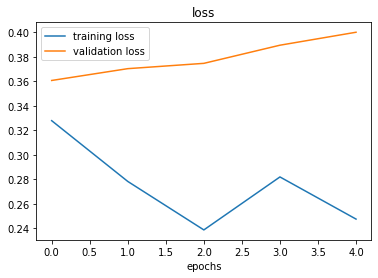

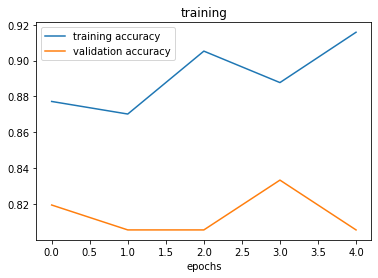

In [103]:
plot_loss_curve(model_history)

### Conclusion

The model performed reasonably well on test data at 83%
However, it looks like it starts to overfit
If I had more time i would add more epchs but also add a callback to the model to see how the loss performs over more epochs.
I would adjust the hyperparameters as well to see if I can improve the model in the future
I would try to add in more data from and see how the model performs when adding in more classes. 